In [36]:
from pathlib import Path
import os

yr = 2024
d = 14

inp_path = os.path.join(Path(os.path.abspath("")).parents[2], 
             'Input', '{}'.format(yr), 
             '{}.txt'.format(d))

with open(inp_path, 'r') as file:
    inp = file.readlines()

In [37]:
wallx, wally = 101, 103


class Robot:
  def __init__(self, pos, vel):
    self.history = [pos]
    self.vel = vel
  
  def move(self):
    self.history.append(((self.loc()[0]+self.vel[0])%wallx, 
                         (self.loc()[1]+self.vel[1])%wally))
    return self

  def loc(self):
    return self.history[-1]
  
  def __str__(self):
    return f"Velocity: {self.vel}\nLoc: {self.loc()}"
  
  def __repr__(self):
    return str(self)
  

class FastRobot(Robot):

  def __init__(self, robot):
    self.location = robot.loc()
    self.vel = robot.vel
    self.moves = len(robot.history)-1

  def move(self):
    self.location = ((self.loc()[0]+self.vel[0])%wallx, 
                (self.loc()[1]+self.vel[1])%wally)
    self.moves += 1
    return self

  def loc(self):
    return self.location

  def __str__(self):
    return f"Velocity: {self.vel}\nLoc: {self.loc()}"
  
  def __repr__(self):
    return str(self)
  

def format_input(inp):
  import re
  m = lambda x: re.match('p\=(\-?\d+),(\-?\d+) v\=(\-?\d+),(\-?\d+)', x)
  return list(map(lambda x: Robot(x[0], x[1]), [(
            (int(m(l).group(1)), int(m(l).group(2))), 
            (int(m(l).group(3)), int(m(l).group(4)))
          ) for l in inp]))

In [38]:
def move(robots, n=100):
  import copy
  robots = copy.deepcopy(robots)
  for _ in range(n):
    robots = [r.move() for r in robots]
  return robots

def get_safety_factor(robots):
  q1 = len([r for r in robots if r.loc()[0]<(wallx//2) and r.loc()[1]<(wally//2)])
  q2 = len([r for r in robots if r.loc()[0]>(wallx//2) and r.loc()[1]<(wally//2)])
  q3 = len([r for r in robots if r.loc()[0]<(wallx//2) and r.loc()[1]>(wally//2)])
  q4 = len([r for r in robots if r.loc()[0]>(wallx//2) and r.loc()[1]>(wally//2)])
  return q1 * q2 * q3 * q4


def check_quadrant_symmmetry(robots, i=None):
  from collections import Counter
  loc_count = Counter([r.loc() if i is None else r.history[i] for r in robots])
  singles = [r for r in robots if (loc_count[r.loc()]==1 if i is None else loc_count[r.history[i]]==1)]
  q1 = len([r for r in singles if r.loc()[0]<(wallx//2) and r.loc()[1]<(wally//2)])
  q2 = len([r for r in singles if r.loc()[0]>(wallx//2) and r.loc()[1]<(wally//2)])
  q3 = len([r for r in singles if r.loc()[0]<(wallx//2) and r.loc()[1]>(wally//2)])
  q4 = len([r for r in singles if r.loc()[0]>(wallx//2) and r.loc()[1]>(wally//2)])
  return q1==q2 and q3==q4


def get_contiguous(robots):
  from functools import reduce

  dirs = [(-1,-1),
  (-1,0),
  (0,-1),
  (1,1),
  (1,0),
  (0,1),
  (-1,1),
  (1,-1)]


  def add_tuple(a, b):
    return (a[0]+b[0], a[1]+b[1])

  locs = [r.loc() for r in robots]
  loc_to_region = {}
  for loc in sorted(locs):
    neighbors = [add_tuple(loc, dir) for dir in dirs]
    neighbor_locs = [k for k in loc_to_region.keys() if k in neighbors]
    if len(neighbor_locs) == 0:
      loc_to_region[loc] = {loc}
    else:
      regions = [loc_to_region[neighbor_loc] for neighbor_loc in neighbor_locs]
      new_region = reduce(lambda x, y: x.union(y), regions).union({loc})
      for neighbor in neighbor_locs + [loc]:
        loc_to_region[neighbor] = new_region
  return list(set(map(tuple, loc_to_region.values())))


def plot_robots(robots, i=None, n=None):
  import matplotlib.pyplot as plt
  import numpy as np

  from  matplotlib.colors import LinearSegmentedColormap
  c = ["darkred", "white", "darkgreen"]
  v = [0,.5,1.]
  l = list(zip(v,c))
  cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

  arr = np.zeros((wally, wallx))

  for r in robots:
    x, y = r.loc() if i == None else r.history[i]
    arr[y][x] += 1

  fig, axes = plt.subplots(figsize=(7.5,7.5))
  fig.tight_layout()
  plt.imshow(arr, cmap=cmap, interpolation='none')
  plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
  if n is not None:
    plt.title(str(n), fontsize=20)
  plt.show()


def find_tree(formatted_input):
  fast_robots = [FastRobot(r) for r in formatted_input]
  i = 1
  biggest_contig = max(get_contiguous(fast_robots), key=len)
  while(len(biggest_contig)) < (len(fast_robots)*.45):
    i += 1
    if fast_robots[0].moves <= i:
      fast_robots = move(fast_robots, i-fast_robots[0].moves+1)
      biggest_contig = max(get_contiguous(fast_robots), key=len)
  print(i+1)
  print('\n')
  plot_robots(fast_robots, None, n=f'{i+1} Seconds')



218965032
7037




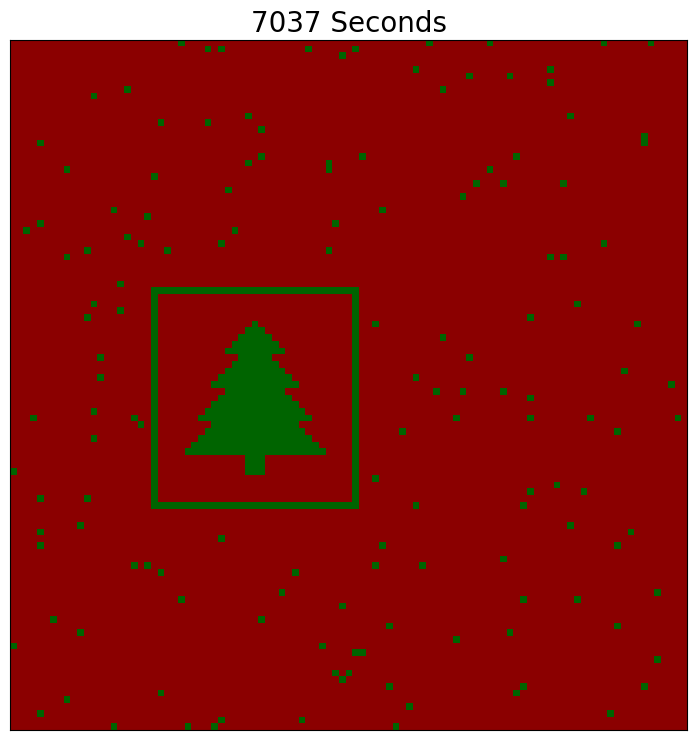


RUNTIME:  158.25789785385132


In [39]:
import time

t = time.time()

formatted_input = format_input(inp)

print(get_safety_factor(move(formatted_input, 100)))
find_tree(formatted_input)

print('\nRUNTIME: ', time.time()-t)